# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2024

# Week 3

# § Network flows and linear programming

# Overview

So far we have looked at a few examples of linear programs. The key step
in modeling these problems is to write down the program itself.

As we saw, for simple programs, such as the carpenter problem, we can
figure it out geometrically. There were only a few variables and a few
obvious constraints and it was easy to check all the “vertices.”

# Network flows

We are going to consider some more complex situations for which we will
use a *network flow* to help produce the corresponding \*linear program.

Let’s recall that a *directed graph* is a pair $G = (V,E)$ where the
elements of the set $V$ are the *vertices* of the graph, and where
$E ⊂ V × V$ are the *edges* of $G$. Thus, an element $e = (a,b) ∈ E$
represents a directed edge from vertex $a$ to vertex $b$.

A node is a *source* if it only appears in outgoing edges, and a node is
a *sink* if it only appears in incoming edges.

For example, `S` is a source and `T` is a sink in the following directed
graph.

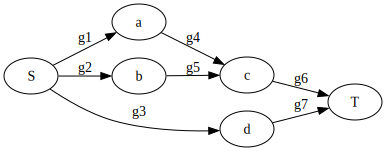

In [4]:
from graphviz import Digraph as GVDigraph
import numpy as np
from scipy.optimize import linprog
import math
from dataclasses import dataclass, field

#-------------------------------
## "standard basis vector"
##
def sbv(index,size):
    return np.array([1.0 if i == index else 0.0 for i in range(size)])

def from_indices(dat,length):
    ## dat is a list [(c,i).,,,] of pairs; the pair (c,i) determines
    ## the vector c*e_i where e_i is the ith standard basis vector
    ## from_indices(dat,length) function returns the sum of the vectors 
    ## specified by the list dat
    return sum([c*sbv(i,length) for (c,i) in dat],np.zeros(length))

## >>> from_indices([(2,3),(3.5,6)],7)
## array([ 0.,  0., 2., 0.,  0.,  3.5,  0.])

#-----------------------------

def flatten(ll : list[list[any]]) -> list[any]:
    return [ i for l in ll for i in l ]

@dataclass
class UpperBound:
    bound: int = math.inf

    
@dataclass
class LowerBound:
    bound: int = -math.inf

    
@dataclass
class Edge:
    vp: (str,str)
    label: str
    val: float = 0.0
    bd: UpperBound | LowerBound = field(default=UpperBound)

@dataclass
class Digraph:
    vertices: list[list[str]]
    edges: list[Edge] 
    title: str

    def drawGraph(self):
        dot = GVDigraph(self.title)
        dot.attr(rankdir='LR')

        
        for vg in self.vertices:
            with dot.subgraph() as c:
                c.attr(rank='same')
                for x in vg:
                    c.node(x)

                    
        vv = flatten(self.vertices)
                    
        for e in self.edges:
            a,b = e.vp
            if (a in vv) and (b in vv):
                dot.edge(a,b,label=format(e.label))

        return dot
        
    
    def drawSubgraph(self,vertices:list[str] = None):
        dot = GVDigraph(self.title)
        dot.attr(rankdir='LR')

        vs = vertices if vertices else flatten(self.vertices)
        
        for x in vs:
            dot.node(x)

        for e in self.edges:
            a,b = e.vp
            if (a in vs) and (b in vs):
                dot.edge(a,b,label=format(e.label))

        return dot

    def getIncoming(self,vertex: str):
        return filter(lambda e: e.vp[1] == vertex, self.edges)
  
    def getOutgoing(self,vertex: str):
        return filter(lambda e: e.vp[0] == vertex, self.edges)

    def edgeVector(self,edge: Edge):
        i = self.edges.index(edge)
        N = len(self.edges)
        return sbv(i,N)
    
    def conservationVector(self,vertex: str):
        ivect = np.sum([self.edgeVector(e) for e in self.getIncoming(vertex)],axis=0)
        ovect = np.sum([self.edgeVector(e) for e in self.getOutgoing(vertex)],axis=0)
        return ivect - ovect

    def conservationLaw(self,vertex: str):
        ii = list(map(lambda x: x.label,self.getIncoming(vertex)))
        oo = list(map(lambda x: x.label,self.getOutgoing(vertex)))
        return "".join([ii.__repr__(),
                        " - ",
                        oo.__repr__(),
                        " = 0"])

    
    def edgeBounds(self,edge: Edge):
        match edge.bd:
            case LowerBound(bound):
                if bound > -math.inf:
                    return ((-1)*self.edgeVector(edge),(-1)*bound)
            case UpperBound(bound):
                if bound < math.inf:
                    return (self.edgeVector(edge),bound)

    def describeEdgeBound(self,edge):
        match edge.bd:
            case LowerBound(bound):
                if bound > -math.inf:
                    return edge.label + ">=" + f"{bound}"
            case UpperBound(bound):
                if bound < math.inf:
                    return edge.label + "<=" + f"{bound}"
            
                
    def allbounds(self):
        info = [self.edgeBounds(e) for e in self.edges ]
        A_ub = np.array([c[0] for c in info if c is not None])
        b_ub = np.array([c[1] for c in info if c is not None])
        return (A_ub,b_ub)

    def describeBounds(self):
        dd = map(lambda e: self.describeEdgeBound(e),self.edges)
        return [d for d in dd if not d is None]
    
    def objectiveVector(self):
        return np.sum([ e.val * self.edgeVector(e)
                        for e in self.edges if e.val is not None],
                      axis=0)

                
@dataclass(kw_only=True)
class networkFlow(Digraph):
    source: str 
    sink: str 
    

    def __post_init__(self):
        Digraph.__init__(self,vertices=self.vertices,edges=self.edges,title=self.title)

    def internalVertices(self):
        return [ v for v in flatten(self.vertices) if not v in [ self.source, self.sink]]

    def conservationMatrix(self):
        return [self.conservationVector(v) for v in self.internalVertices()]


    def conLaws(self):
        return [self.conservationLaw(v) for v in self.internalVertices()]
    
    def runLinProgr(self,maximize=False):
        A_ub,b_ub = self.allbounds()
        A_eq = self.conservationMatrix()
        if maximize:
            c = (-1)*self.objectiveVector()
        else:
            c = self.objectiveVector()
        return linprog(c,
                       A_eq=A_eq,
                       b_eq=np.zeros(len(self.internalVertices())),
                       A_ub=A_ub,
                       b_ub = b_ub)
    
vv = [ ['S'],['a','b'],['c','d'],['T']]
ee = [ Edge(('S','a'),'g1',bd=LowerBound(2),val=10),
       Edge(('S','b'),'g2',bd=LowerBound(2),val=20),
       Edge(('S','d'),'g3',bd=LowerBound(2),val=30),
       Edge(('a','c'),'g4'),
       Edge(('b','c'),'g5'),
       Edge(('c','T'),'g6',val=-10),
       Edge(('d','T'),'g7')
       ]

#nf = Digraph(vertices=vv,edges=ee)
nf = networkFlow(vertices=vv,edges=ee,title='Example',source='S',sink='T')

nf.format='png'
nf.drawGraph()

#nf.conservationMatrix()
#nf.allbounds()
#nf.runLinProgr()

# Restaurant Example

Suppose that you are opening a new restaurant and need to make sure you
have enough clean tablecloths to meet expected demand in the first week.
On each day, you can buy new tablecloths for \\\$ 5. Used tablecloths
can be laundered and returned the next day for \\\$2 or the following
day for \$1.

Your expected tablecloth demands are:

| Day                | 1   | 2   | 3   | 4   | 5   | 6   | 7   |
|:-------------------|:----|:----|:----|:----|:----|:----|:----|
| tablecloths needed | 10  | 10  | 15  | 20  | 40  | 40  | 30  |

Let’s try to formulate a linear program to minimize the costs.

Let’s name the quantities from the table.

-   $t_i$ = expected \# of tablecloths required on day $i$.

Now introduce variables:

-   $b_i$ = \# tablecloths bought on day $i$, $1 ≤ i ≤ 7$.
-   $f_i$ = \# dirty tablecloths sent to fast laundry on day $i$
-   $s_i$ = \# dirty tablecloths sent to slow laundry on day $i$

First, let’s write down the objective (assuming we only care about week
1):

The goal is to minimize the quantity

$$5 \sum_{i=1}^7 b_i + 2\sum_{i=1}^6 f_i + \sum_{i=1}^5 s_i.$$

What are the constraints? On day $i$, we must have at least $t_i$
tablecloths available.

-   day 1

    we need enough tablecloths for day 1, so $$t_1 \le b_1$$

-   day 2

    demand must be met from purchases on day 2, plus surplus from day 1,
    plus fast laundry from day 1. note that the *use* on day 1 is equal
    to $f_1 + s_1$ and thus $b_1 - f_1 - s_1$ counts the surplus from
    day 1. So we need

    $$t_2 \le b_2 + (b_1 - f_1 - s_1) + f_1$$

-   day 3

    demand must again be met from purchases on day 3, plus leftover from
    the previous days, plus those laundered from the fast service on day
    2, and those laundered via the slow service on day 1. The total used
    in the first two days is equal to $f_1 + s_1 + f_2 + s_2$, so the
    surplus from the first two days is
    $b_1 + b_2 - f_1 - s_1 - f_2 - s_2$. So we need

    $$t_3 \le b_3 + (b_1 + b_2 - f_1 - s_1 - f_2 - s_2) + f_2 + s_1$$

etc.

This becomes increasingly hard to keep track of and formulate.

So, instead, we build what’s called a network model and we track the
flow of tablecloths!

Let’s use a tool called `graphviz` to draw part of a diagram:

In [2]:
tt = np.array([10,10,15,20,40,40,30])

clean = [ f"d{d} clean" for d in range(7) ]
used  = [ f"d{d} used"  for d in range(7) ]

vv = [['source'], clean, used]


ee = [*[ Edge(('source',clean[d]),   label=f"b{d}", val=5) # bought
         for d in range(7)
        ],   
      *[ Edge((clean[d],used[d]),    label=f"u{d}", bd=LowerBound(tt[d])) # usage
         for d in range(7)
        ],  
      *[ Edge((clean[d],clean[d+1]), label=f"c{d}" )       # carry-over
        for d in range(6)
       ],  
      *[ Edge((used[d],clean[d+1]),  label=f"f{d}", val=2) # fast laundry
        for d in range(6)
       ], 
      *[ Edge((used[d],clean[d+2]),  label=f"s{d}", val=1) # slow laundry
        for d in range(5)
       ]
      ]

def report(result: scipy.optimize.OptimizeResult) -> str:
    """the argument ``result`` should be an instance of the class ``scipy.optimize.OptimizeResult`` -- 
    i.e. a value of the form returned by ``linprog``
    """
    x = result.x
    costs = result.fun
    return "\n".join(
        [f"linprog succeeded? {result.success}",
         f"Optimal tablecloth expenses for the week are ${costs:.2f}",
         "This is achieved by the following strategy:",
         *[f"purchase on day {i}: {x[i]:.2f}" for i in range(7)],
         "",
         *[f"use on day {i+1}: {x[6+i]:.2f}" for i in range(7)],
         "",
         *[f"carry-over from day {i} to day {i+1}: {x[13+i]:.2f}" for i in range(6)],
         "",
         *[f"fast laundry on day {i}: {x[19+i]:.2f}" for i in range(6)],
         "",
         *[f"slow laundry on day {i}: {x[19+i]:.2f}" for i in range(5)],
         ])
        


nf = networkFlow(vv,ee,title="Restaurant",source='source',sink='d6 used')

nf.makeGraph().render()

lp = nf.runLinProgr()
print(report(lp))

NameError: name 'scipy' is not defined

In [ ]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

def clean_node(day):
    return f"d{day}c"

def used_node(day):
    return f"d{day}u"

def make_network_model(last):

   dot = Digraph('tablecloth network model')

   dot.attr(rankdir='LR')
   dot.node('s','source of new tablecloths')
   days = range(1,last + 1)

   with dot.subgraph(name='clean') as c:
     c.attr(rank='same')
     for day in days:
        if day == last:
            c.node(clean_node(day),"etc...")
        else:        
            c.node(clean_node(day), f"day {day} clean")

   with dot.subgraph(name='used') as u:
     u.attr(rank='same')
     for day in days:
        if day == last:
            u.node(used_node(day),'etc...')
        else:        
            u.node(used_node(day), f"day {day} used")

   for day in days:
     dot.edge('s',clean_node(day),label='cost=5')
     if day < last:
        dot.edge(clean_node(day),clean_node(day+1), label = "cost=0")

     dot.edge(clean_node(day),used_node(day),label=f"cost=0,ℓ=t_{day}")

     if day < last:
        dot.edge(used_node(day),clean_node(day+1),label="cost=2") ## fast laundry

     if day < last -1:
        dot.edge(used_node(day),clean_node(day+2),label="cost=1") ## slow laundry

   return dot
  
make_network_model(last=5)

(extrapolate the diagram for the remaining days…)

------------------------------------------------------------------------

How do we make a linear program of this??

The above diagram represents a *directed graph*. The edges in this graph
– i.e. the arrows between nodes – track the “flow” of tablecloths.

-   We introduce a variable for each arrow. The value of the variable
    represents the number of tablecloths that move from the start to
    finish of the arrow.

-   Some arcs have lower bounds (e.g. $\ell$ = t_1). If no lower bound
    is mentioned, there is an implied lower bound of 0.

-   Some arcs have upper bounds. These model maximum supply or
    throughput. Nothing implies a bound of $\infty$.

-   Each “internal” node has conservation –
    i.e. `outputs - inputs =   0`.

-   Each arc has a cost. The Objective function is the sum of the
    quantities (arc costs $\times$ flow variable).

Remember that we write

-   $t_i$ = \# tablecloths needed on day $i$.

    (these aren’t *variables* for our linear program – they are values
    given to us by the problem).

Since we are to have one variable for each arrow in the above diagram,
we write:

-   $b_i$ = \# tablecloths bought on day $i, 1 ≤ i ≤ 7$.
-   $u_i$ = \# tablecloths used on day $i, 1 ≤ i ≤ 7$.
-   $c_i$ = \# tablecloths carried over from day $i$ to $i + 1$ for
    $0 \le i \le 6$
-   $f_i$ = \# dirty tablecloths sent to fast laundry on day $i$ for
    $0 \le i \le 6$
-   $s_i$ = \# dirty tablecloths sent to slow laundry on day $i$ for
    $0 \le i \le 5$

Now the objective equation has the form:

$$5\sum_{i=1}^7 b_i + 0 \sum_{i=1}^7 u_i + 0 \sum_{i=1}^6 c_i + 2
\sum_{i=1}^6 f_i + \sum_{i=1}^5 s_i$$

We require $t_i \le u_i$ for $1 \le i \le 7$ (lower bounds). These lower
bounds arise from the arrows from “Day i clean” to “Day i used” with the
label $\ell = t_i$.

We impose no upper bounds on the variables.

For each node, we get a conservation equation:

-   node “day 1 clean”: $u_1 + c_1 − b_1 = 0$
-   node “day 1 used”: $s_1 + f_1 − u_1 = 0$
-   node “day 2 clean”: $u_2 + c_2 − b_2 − c_1 − f_1 = 0$
-   node “day 2 used”: $s_2 + f_2 − u_2 = 0$
-   node “day 3 clean”: $u_3 + c_3 − b_3 − c_2 − f_2 − s_1 = 0$
-   node “day 3 used”: $s_3 + f_3 − u_3 = 0$
-   and so on…

Note for example that 2 arrows leave and 3 arrows arrive at the node
“Day 2 clean”, while 2 arrows leave and 4 arrows arrive at the node “Day
3 clean”. The above equations reflect these counts.

## Remarks:

-   There are $2 \times 7 + 2 \times 6 + 5 = 31$ variables. So the
    objective function is given by a vector
    $\mathbf{c} \in \mathbb{R}^{1 \times 31}$.

-   there are 13 “equality constraints” arising from the conservation
    equation at each node (note that there is no conservation at the
    node “day 7 used”, since it is a terminal node). Thus the equality
    constraints are given by a $13 \times 31$ matrix $A$ (they amount to
    the condition $A\mathbf{x} = \mathbf{0}$ for
    $\mathbf{x} \in \mathbb{R}^{31} = \mathbb{R}^{31 \times 1}$).

-   there are 7 inequality constraints, given by the condition
    $B \mathbf{x} \le \mathbf{b}$ for a $7 \times 31$ matrix $B$ and a
    vector $\mathbf{b} \in \mathbb{R}^7 = \mathbb{R}^{7 \times 1}$.

## Implementation (sketch)

The main task in solving this model via `python` is producing the
matrices $A$ and $B$.

For example, the conservation at the node

-   node “day 3 clean”: $u_3 + c_3 − b_3 − c_2 − f_2 − s_1 = 0$

results in a *row* of the matrix $A$.

Let’s order the variables as follows:
$$b_1,b_2,\dots,b_7,u_1,\dots,u_7,c_1,\dots,c_6,f_1,\dots,f_6,s_1,\dots,s_5$$

We want to write rows of $A$ in the form

$$(\heartsuit) \quad \begin{bmatrix} \mathbf{\widetilde b} &
\mathbf{\widetilde u} & \mathbf{\widetilde c} & \mathbf{\widetilde f}
& \mathbf{\widetilde s} \\ \end{bmatrix} \in \mathbb{R}^{1 \times
31}$$

where

$$\mathbf{\widetilde b},\mathbf{\widetilde u} \in \mathbb{R}^{1 \times
7}, \quad \mathbf{\widetilde c},\mathbf{\widetilde f} \in
\mathbb{R}^{1 \times 6}, \quad \mathbf{\widetilde s} \in \mathbb{R}^{1
\times 5},$$

the row vector $(\heartsuit)$ is to be understood as obtained by
“*concatenation*” of these vectors, and we have:

$$\mathbf{\widetilde b} = \begin{bmatrix} 0 & 0 & -1 & 0 & 0 & 0 & 0
\end{bmatrix} = -\mathbf{e}_3, \quad \mathbf{\widetilde u} =
\mathbf{e}_3,$$

$$\mathbf{\widetilde c} = \begin{bmatrix} 0 & -1 & 1 & 0 & 0 & 0
\end{bmatrix} = \mathbf{e}_3 -\mathbf{e}_2, \quad \mathbf{\widetilde f} =
\begin{bmatrix} 0 & -1 & 0 & 0 & 0 \end{bmatrix} = -\mathbf{e}_2,
\quad\mathbf{\widetilde s} = -\mathbf{e}_1$$

(here $\mathbf{e}_i$ represents the appropriate standard basis vector in
$\mathbb{R}^7$, $\mathbb{R}^6$ or $\mathbb{R}^5$).

In [ ]:
## This code represents a preliminary implementation
## it just gives the row in the equality constraint corresponding
## to a single row. See the next cell for a "full implementation"

import numpy as np

def sbv(index,length):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(length)])

## produce the row corresponding to the "day 3 clean" node.
##
row = np.block([(-1)*sbv(3,7), ## bb
                 sbv(3,7),       ## uu
                 (-1)*sbv(2,6) + sbv(3,6),  ## cc
                 (-1)*sbv(2,6),       ## ff
                 (-1)*sbv(1,5)       ## ss
               ])

## Note that if you had constructed the following rows -- row1, row2, row3, ..., row7 -- you'd produce the matrix A via
## A = np.array([row1,row2,row3,...,row7])

print(row.shape)
print(row)

In [ ]:
## This cell represents one possible way of creating the equality and inquality constraints
## for the "tablecloth" problem

import numpy as np
from scipy.optimize import linprog

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## "standard basis vector"
##
def sbv(index,size):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(size)])

def from_indices(dat,length):
    ## dat is a list [(c,i).,,,] of pairs; the pair (c,i) determines
    ## the vector c*e_i where e_i is the ith standard basis vector
    ## from_indices(dat,length) function returns the sum of the vectors 
    ## specified by the list dat
    return sum([c*sbv(i,length) for (c,i) in dat],np.zeros(length))

## >>> from_indices([(2,3),(3.5,6)],7)
## array([ 0.,  0., 2., 0.,  0.,  3.5,  0.])

def row(b=[],
        u=[],
        c=[],
        f=[],
        s=[]):
    bb = from_indices(b,7)
    uu = from_indices(u,7)
    cc = from_indices(c,6)
    ff = from_indices(f,6)
    ss = from_indices(s,5)
    return np.block([bb,uu,cc,ff,ss])

## >>> row(bp=[1],un=[2])
## array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
##        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
##        0.,  0.,  0.,  0.,  0.])
##
## this result has a 1 in the "1st entry of the b-group" and a -1 in
## the "2nd entry of the u-group"


## here is a textual description of the "equality constraint" matrix.
## We then proceed to implement this description using the function `row` 
## defined above.
##
## day1 clean: b1 - u1 - c1 = 0
## day2 clean: b2 + c1 + f1 - u2 - c2 = 0
## day3 clean: b3 + c2 + s1 + f2 - u3 - c3 = 0
## day4 clean: b4 + c3 + s2 + f3 - u4 - c4 = 0
## day5 clean: b5 + c4 + s3 + f4 - u5 - c5 = 0
## day6 clean: b6 + c5 + s4 + f5 - u6 - c6 = 0
## day7 clean: b7 + c6 + s5 + f6 - u7 = 0

## day1 used:  u1 - s1 - f1  = 0
## day2 used:  u2 - s2 - f2  = 0
## day3 used:  u3 - s3 - f3  = 0
## day4 used:  u4 - s4 - f4  = 0
## day5 used:  u5 - s5 - f5  = 0
## day6 used:  u6 - f6   = 0

## Note that day7 used is a "terminal node" so doesn't have a conservation equation.

## the rc are rows corresponding to conservation laws for "clean" nodes

rc1 = row(b=[(1,1)],c=[(-1,1)],                   u=[(-1,1)])
rc2 = row(b=[(1,2)],c=[(1,1),(-1,2)],          f=[(1,1)],u=[(-1,2)])
rc3 = row(b=[(1,3)],c=[(1,2),(-1,3)],s=[(1,1)],f=[(1,2)],u=[(-1,3)])
rc4 = row(b=[(1,4)],c=[(1,3),(-1,4)],s=[(1,2)],f=[(1,3)],u=[(-1,4)])
rc5 = row(b=[(1,5)],c=[(1,4),(-1,5)],s=[(1,3)],f=[(1,4)],u=[(-1,5)])
rc6 = row(b=[(1,6)],c=[(1,5),(-1,6)],s=[(1,4)],f=[(1,5)],u=[(-1,6)])
rc7 = row(b=[(1,7)],c=[(1,6),(-1,7)],s=[(1,5)],f=[(1,6)],u=[(-1,7)])

## the ru are rows corresponding to conservation laws for "used" nodes

ru1 = row(u=[(1,1)],s=[(-1,1)],f=[(-1,1)])
ru2 = row(u=[(1,2)],s=[(-1,2)],f=[(-1,2)])
ru3 = row(u=[(1,3)],s=[(-1,3)],f=[(-1,3)])
ru4 = row(u=[(1,4)],s=[(-1,4)],f=[(-1,4)])
ru5 = row(u=[(1,5)],s=[(-1,5)],f=[(-1,5)])
ru6 = row(u=[(1,6)],           f=[(-1,6)])

## the rc and ru determined the rows of the matrix defining 

Aeq = np.array([rc1,rc2,rc3,rc4,rc5,rc6,rc7,
                ru1,ru2,ru3,ru4,ru5,ru6])


Alb = np.array([row(u=[(1,i)]) for i in range(1,8)])

## objective function
c = row(b=[(5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7)],
        f=[(2,1),(2,2),(2,3),(2,4),(2,5),(2,6)],
        s=[(1,1),(1,2),(1,3),(1,4),(1,5)])


tt = np.array([10,10,15,20,40,40,30]) ## these are the ti entries taken from the "tablecloths needed" table


## use linprog to find the point which minimizes the objective function
## we impose equality constraints  Aeq*x=0.
## we also want the inequality constraint Ax >= tt, so we use -Ax <= -tt.
result = linprog(c,A_eq=Aeq,b_eq=np.zeros(13),A_ub=(-1)*Alb,b_ub=(-1)*tt)

def report(result):
    ## the argument ``result`` should be an instance of the class ``scipy.optimize.OptimizeResult`` -- 
    ## i.e. a value of the form returned by ``linprog``
    ##
    x = result.x
    costs = result.fun
    return "\n".join(
        [f"linprog succeeded? {result.success}"]
        +
        [f"Optimal costs on tablecloths for the week are ${costs:.2f}"]
        + 
        ["This is achieved by the following strategy:\n"]
        +
        [f"purchase on day {i+1}: {x[i]:.2f}" for i in range(7)]
        + 
        [""]
        + 
        [f"use on day {i+1}: {x[7+i]:.2f}" for i in range(7)]
        + 
        [""]
        + 
        [f"carry over from day {i+1} to day {i+2}: {x[14+i]:.2f}" for i in range(6)]
        + 
        [""]        
        + 
        [f"to fast laundry on day {i+1}: {x[20+i]:.2f}" for i in range(6)]
        + 
        [""]        
        + 
        [f"to slow laundry on day {i+1}: {x[26+i]:.2f}" for i in range(5)])

print(report(result))

The idea is that “network flow” graphs are a tool to help formulate the
linear program. Here is another example.

# Grocery example

A fruit wholesaler buys and sells apples according to the following
prices and demand:

| Month                |  Aug |  Sep |  Oct |  Nov |  Dec |  Jan |  Feb |  Mar |  Apr |  May |  Jun |  Jul |
|:---------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| price/kg from grower | 0.80 | 0.55 | 0.55 | 0.65 | 0.75 | 0.85 | 0.95 |   \- |   \- |   \- |   \- |   \- |
| sale price/kg        | 0.90 | 0.65 | 0.65 | 0.85 | 1.00 | 1.00 | 1.20 | 1.20 | 1.20 | 1.00 | 0.80 | 0.80 |
| demand in 1000kg     |   10 |   15 |   15 |   15 |   13 |   10 |   10 |   10 |    9 |    7 |    5 |    5 |

The wholesaler can store 50,000kg at a cost of \$0.025 per kg per month.
Unlimited supplies are available from September to January but only
15,000kg are available in August and February and none during the rest
of the year.

We consider the profit for a year (12 months), from August to the next
July. We suppose that there are *no* apples to carry over from the
previous month – we begin with no apples.

Our goal: Maximize the profit!

We’ll begin by formulating the flow model.

Remember that each edge in the graph corresponds to a variable in our
linear program. We are going to label each edge with a symbol
$[c,u,\ell]$ representing the “cost” (i.e. the contribution of that
variable to the objective function), an upper bound $u$ for that
variable, and a lower bound $\ell$ for that variable.

We are going to construct the diagram using `graphviz`, though the main
point here is the diagram itself rather than the code used to produce
it. (I’m including the code so you can copy it if you wish).

In [ ]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Digraph('fruit wholesaler model')

dot.attr(rankdir='LR')
dot.node('g','grower')

with dot.subgraph(name='months') as c:
    c.attr(rank='same')
    c.node('aug')
    c.node('sep')
    c.node('oct')
    c.node('nov')
    c.node('feb')
    c.node('mar')

    
dot.node('d','demand')

dot.edge('g','aug',label='[-.8,15000,0]')
dot.edge('g','sep',label='[-.55,∞,0]')
dot.edge('g','oct',label='[-.55,∞,0]')
dot.edge('g','nov',label='[-.65,∞,0]')
dot.edge('g','feb',label='[-.95,15000,0]')

dot.edge('aug','sep',label='[-0.025,50K,0]')
dot.edge('sep','oct',label='[-0.025,50K,0]')
dot.edge('oct','nov',label='[-0.025,50K,0]')
dot.edge('feb','mar',label='[-0.025,50K,0]')


dot.edge('aug','d',label='[0.9,10000,0]')
dot.edge('sep','d',label='[0.65,15000,0]')
dot.edge('oct','d',label='[0.65,15000,0]')
dot.edge('nov','d',label='[0.85,15000,0]')
dot.edge('feb','d',label='[1.20,10000,0]')
dot.edge('mar','d',label='[1.20,10000,0]')

    
dot

#dot.format='png'
#dot.render()

Now let’s formulate the linear program.

Let’s number our months in a slightly odd way. Our year starts in
`august`, so we number as follows:

| `aug` | `sep` | `oct` | `nov` | `dec` | `jan` | `feb` | `mar` | `apr` | `may` | `jun` | `jul` |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |    10 |    11 |    12 |

We need to name our variables; we’ll use the above numbering:

-   $g_i$ = \# kg bought in month $i$, for $1 \le i \le 12$.
-   $s_i$ = \# kg stored from month $i$ to month $i+1$
-   $d_i$ = \# kg sold in month $i$

All of our variables are assumed to be non-negative:
$g_i \ge 0, s_i \ge 0, d_i \ge 0$ for all $i$.

We’ve been told the following:

> Unlimited supplies are available (from the grower) from September to
> January but only 15,000kg are available in August and February and
> none during the rest of the year.

This gives us some “upper bound” inequalities:

$$\begin{bmatrix}
    g_1 \\ g_2 \\ g_3 \\ g_4 \\ g_5 \\ g_6 \\ 
    \end{bmatrix}
    \le 
    \begin{bmatrix}
       1500 \\   
       \infty \\ 
       \infty \\ 
       \infty \\ 
       \infty \\
       \infty
    \end{bmatrix}
    \quad \text{and} \quad
    \begin{bmatrix}
    g_7 \\ g_8 \\ g_9 \\ g_{10} \\ g_{11} \\ g_{12}
    \end{bmatrix}
    \le 
    \begin{bmatrix}
    15000 \\
    0 \\
    0 \\
    0 \\
    0 \\
    0
    \end{bmatrix}$$

(since $g_i \ge 0$ is non-negative, the above conditions for
$8 \le i \le 12$ *amount to* an equality condition of $g_i = 0$ for
these $i$, but we’ll enter it as an inequality condition for
uniformity).

We’ve also been told:

> The wholesaler can store 50,000kg at a cost of \$0.025 per kg per
> month.

This yields the upper bound - $s_i \le 50000$ for $1 \le i \le 12$

Now, we know from table the demand for each month. Remember what we are
doing: with the linear program, we are trying to decide the optimal
values of our decision variables – i.e. how many apples do we buy each
month? and how many apples do we store each month? According to the
model, the number of apples we expect to *sell* depends on these choices
(via the conservation laws). So to be sensible, our model must view the
anticipated demand (listed in the table) as an **upper bound** for the
amount we can sell. More precisely, we should impose the constraint that
the number $d_i$ of `kg` of apples delivered to customers is $\le$ the
anticipated demand for each month. (Of course, this is what the label on
the diagram indicates! Here I’m trying to explain why we have chosen
that labeling).

This amount to the condition: $$\begin{bmatrix}
    d_1 \\ d_2 \\ d_3 \\ d_4 \\ d_5 \\ d_6 \\ 
    \end{bmatrix}
    \le 
    \begin{bmatrix}
       10 \\   
       15 \\ 
       15 \\ 
       15 \\ 
       13 \\
       10    \end{bmatrix}
    \quad \text{and} \quad
    \begin{bmatrix}
    d_7 \\ d_8 \\ d_9 \\ d_{10} \\ d_{11} \\ d_{12}
    \end{bmatrix}
    \le 
    \begin{bmatrix}
    10 \\
    10 \\
    9 \\
    7  \\
    5 \\
    5
    \end{bmatrix}$$

Conservation:

The internal nodes of our network flow diagram correspond to months. The
arrow “going in” to the node amount to available apples, and they
correspond to purchases ($g_i$) and storage ($s_{i-1}$ unless $i=1$).
The arrows going out correspond to storage ($s_i$) and to apples
delivered to customers ($d_i$). Thus, we must have

-   $s_1 + d_1 - g_1 = 0$
-   $s_2 + d_2 - g_2 - s_1 = 0$.
-   $s_3 + d_3 - g_3 - s_2 = 0$.
-   $\vdots$

Objective:

The objective function represents profit, and each variable has some
contribution to objective/profit function (we call this contribution
“cost”). We spend money through apple purchases and through storage
costs, and these costs have negative values. We get money through apple
sales, and these costs have positive value.

-   August contribution to the objective function:

    $$\begin{matrix} -0.80g_1 - 0.025s_1 + 0.9d_1 \end{matrix}$$

-   September contribution to the objective function:

    $$\begin{matrix} -0.55g_1 - 0.025s_1 + 0.65d_1 \end{matrix}$$

-   $\cdots$

Of course, the objective function is the *sum* of all 12 of these
monthly contributions.

Implementation follows:

In [ ]:
from scipy.optimize import linprog
import numpy as np


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## "standard basis vector"
##
def sbv(index,size):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(size)])


def from_indices(dat,length):
    ## dat is a list [(c,i).,,,] of pairs; the pair (c,i) determines
    ## the vector c*e_i where e_i is the ith standard basis vector
    return sum([c*sbv(i,length) for (c,i) in dat],np.zeros(length))


def row(g=[],
        s=[],
        d=[]):
    gg = from_indices(g,12)
    ss = from_indices(s,12)
    dd = from_indices(d,12)
    return np.block([gg,ss,dd])

## for uniformity, we actually consider 12 storage variables event though
## we shouldn't really put anything in storage in july (month 12)

## let's form the equality constraint matrix from the conservation laws.

A=np.array([row(s=[(1,1)],d=[(1,1)],g=[(-1,1)])]     # first row
           +
           [row(s=[(1,i),(-1,i-1)],
                d=[(1,i)],
                g=[(-1,i)]) for i in range(2,13)])   # remaining rows

## now let's make the inequality constraint matrix
## our inequality constraint will have the form Ax <= b,
## so any "lower bound" constraints would need to be reversed using a sign change.
## But anyhow we haven't specified any lower bounds...

Bs = [row(s=[(1,i)]) for i in range(1,13)]
bs = np.array([50000 for i in range(1,13)])

## gi bounds

Bg_start = [row(g=[(1,1)]), row(g=[(1,7)])]
Bg_end   = [row(g=[(1,i)]) for i in range(8,13)]

Bg = Bg_start + Bg_end
     
bg = np.array([15000,15000] + 5*[0])  # note that n*[0] is the list [0,0,...,0] with n zeros

## di bounds

Bd = [row(d=[(1,i)]) for i in range(1,13)]
bd = (1000)*np.array([10,15,15,15,13,10,10,10,9,7,5,5])

B = np.array(Bg + Bs + Bd) ## concat the lists of rows; create a matrix from the resulting list
b = np.block([bg,bs,bd])   ## concat the constraints

## objective function

grower_costs = (-1)*np.array([0.8,0.55,0.55,0.65,0.75,0.85,0.95,0,0,0,0,0])
storage_costs = (-1)*np.array(12*[.025])
sale_price = np.array([0.9,0.65,0.65,0.85,1,1,1.2,1.2,1.2,1,.8,.8])

c = np.block([grower_costs,storage_costs,sale_price])

result = linprog((-1)*c,A_eq=A,b_eq=np.zeros(12),A_ub=B,b_ub=b)

def month(i):
    dict={1:"aug",
          2:"sep",
          3:"oct",
          4:"nov",
          5:"dec",
          6:"jan",
          7:"feb",
          8:"mar",
          9:"apr",
          10:"may",
          11:"jun",
          12:"jul"}
    return dict[i]

def report(res):
    ## the argument ``res`` should be an instance of the class ``scipy.optimize.OptimizeResult`` -- 
    ## i.e. a value of the form returned by ``linprog``
    ##
    x=res.x
    profit  = (-1)*result.fun
    return "\n".join([f"linprog succeeded? {result.success}"]
                     +
                     [f"Optimal profit ${profit:,.2f}"]
                     + 
                     ["This is achieved by the following strategy:\n"]
                     +
                     [f"purchase in kg for {month(i+1)}: {x[i]:.2f}" for i in range(12)]
                     + 
                     [""]
                     + 
                     [f"storage in kg for {month(i+1)}: {x[i+12]:.2f}" for i in range(12)]
                     + 
                     [""]                     
                     + 
                     [f"sales in kg for {month(i+1)}: {x[i+24]:.2f}" for i in range(12)])

print(report(result))
